In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Распознавание атрибутов лица

In [149]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## Исследование данных

Для начала загрузим данные. В оригинальном датасете используется 1, если атрибут присутствует, и -1, если нет, но нам удобнее использовать 1 и 0.

In [150]:
PATH = '/content/drive/MyDrive/content/'
IMAGE_PATH = '/content/drive/MyDrive/content/img_align_celeba_17k/img_align_celeba/'
df_attr = pd.read_csv(PATH + 'list_attr_celeba.txt', engine='python', delimiter=' +')
df_attr.replace(to_replace=-1, value=0, inplace=True)
df_attr.head(10)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
000006.jpg,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1
000007.jpg,1,0,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
000008.jpg,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
000009.jpg,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1
000010.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [151]:
df_attr.shape

(202599, 40)

Посмотрим, как же выглядят эти картинки в действительности.

Bangs                  1
Blurry                 1
Brown_Hair             1
Mouth_Slightly_Open    1
No_Beard               1
Young                  1
Name: 010942.jpg, dtype: int64


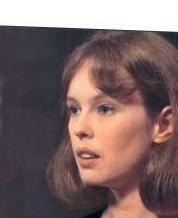

In [152]:
example = '010942.jpg'
big_img = Image.open(IMAGE_PATH + example)
print(df_attr.loc[example][df_attr.loc[example] == 1])
big_img

В рамках данной работы я рассматриваю только 17000 из предложенных изображений, поэтому можно сразу уменьшить наш датасет.

In [153]:
df_size = 17000
df_attr = df_attr[:df_size]
df_attr.shape

(17000, 40)

In [154]:
all_attributes = df_attr.columns

У меня не стоит цель научиться распознавать абсолютно все атрибуты лица, поэтому я хочу выбрать некоторые из них, и в дальнейшем работать только с ними. Для большего интереса выберем признаки с различным распределением. Рассмотрим, какие признаки сбалансированы, а какие нет.

Важно не забывать, что сейчас мы исследуем не признаки (признаком является само изображение), а метки объектов.

In [155]:
def PrintSortedData(condition, df):
    sorted_map = {}
    for attribute in all_attributes:
        sorted_map[attribute] = condition(attribute, df)

    for attr, value in sorted(sorted_map.items(), key=lambda item: item[1]):
        spaces = ' ' * (20 - len(attr)) + '\t'
        print(attr, spaces, value)
    return sorted_map

In [156]:
condition = lambda attr, df: round(df[attr].sum() / df_size, 3)
balanse_map = PrintSortedData(condition, df_attr)

Bald                 	 0.024
Mustache             	 0.04
Gray_Hair            	 0.042
Pale_Skin            	 0.043
Double_Chin          	 0.046
Blurry               	 0.05
Wearing_Hat          	 0.05
Chubby               	 0.057
Sideburns            	 0.058
Goatee               	 0.063
Rosy_Cheeks          	 0.063
Eyeglasses           	 0.066
Wearing_Necktie      	 0.074
Receding_Hairline    	 0.077
5_o_Clock_Shadow     	 0.113
Narrow_Eyes          	 0.116
Wearing_Necklace     	 0.122
Bushy_Eyebrows       	 0.143
Blond_Hair           	 0.149
Bangs                	 0.15
Wearing_Earrings     	 0.187
Bags_Under_Eyes      	 0.204
Brown_Hair           	 0.205
Straight_Hair        	 0.212
Big_Nose             	 0.238
Big_Lips             	 0.239
Black_Hair           	 0.241
Arched_Eyebrows      	 0.265
Pointy_Nose          	 0.275
Oval_Face            	 0.278
Wavy_Hair            	 0.317
Heavy_Makeup         	 0.386
Male                 	 0.422
High_Cheekbones      	 0.45
Wearing_Lipstick   

Рассмотрим также взаимную корреляцию меток. В итоге я хочу сделать нейронную сеть, которая будет одновременно распознавать несколько признаков, поэтому интересно, будет ли влиять их взаимная корреляция. Иными словами, сможет ли сеть использовать знание об одной метке, чтобы лучше распознать другую.

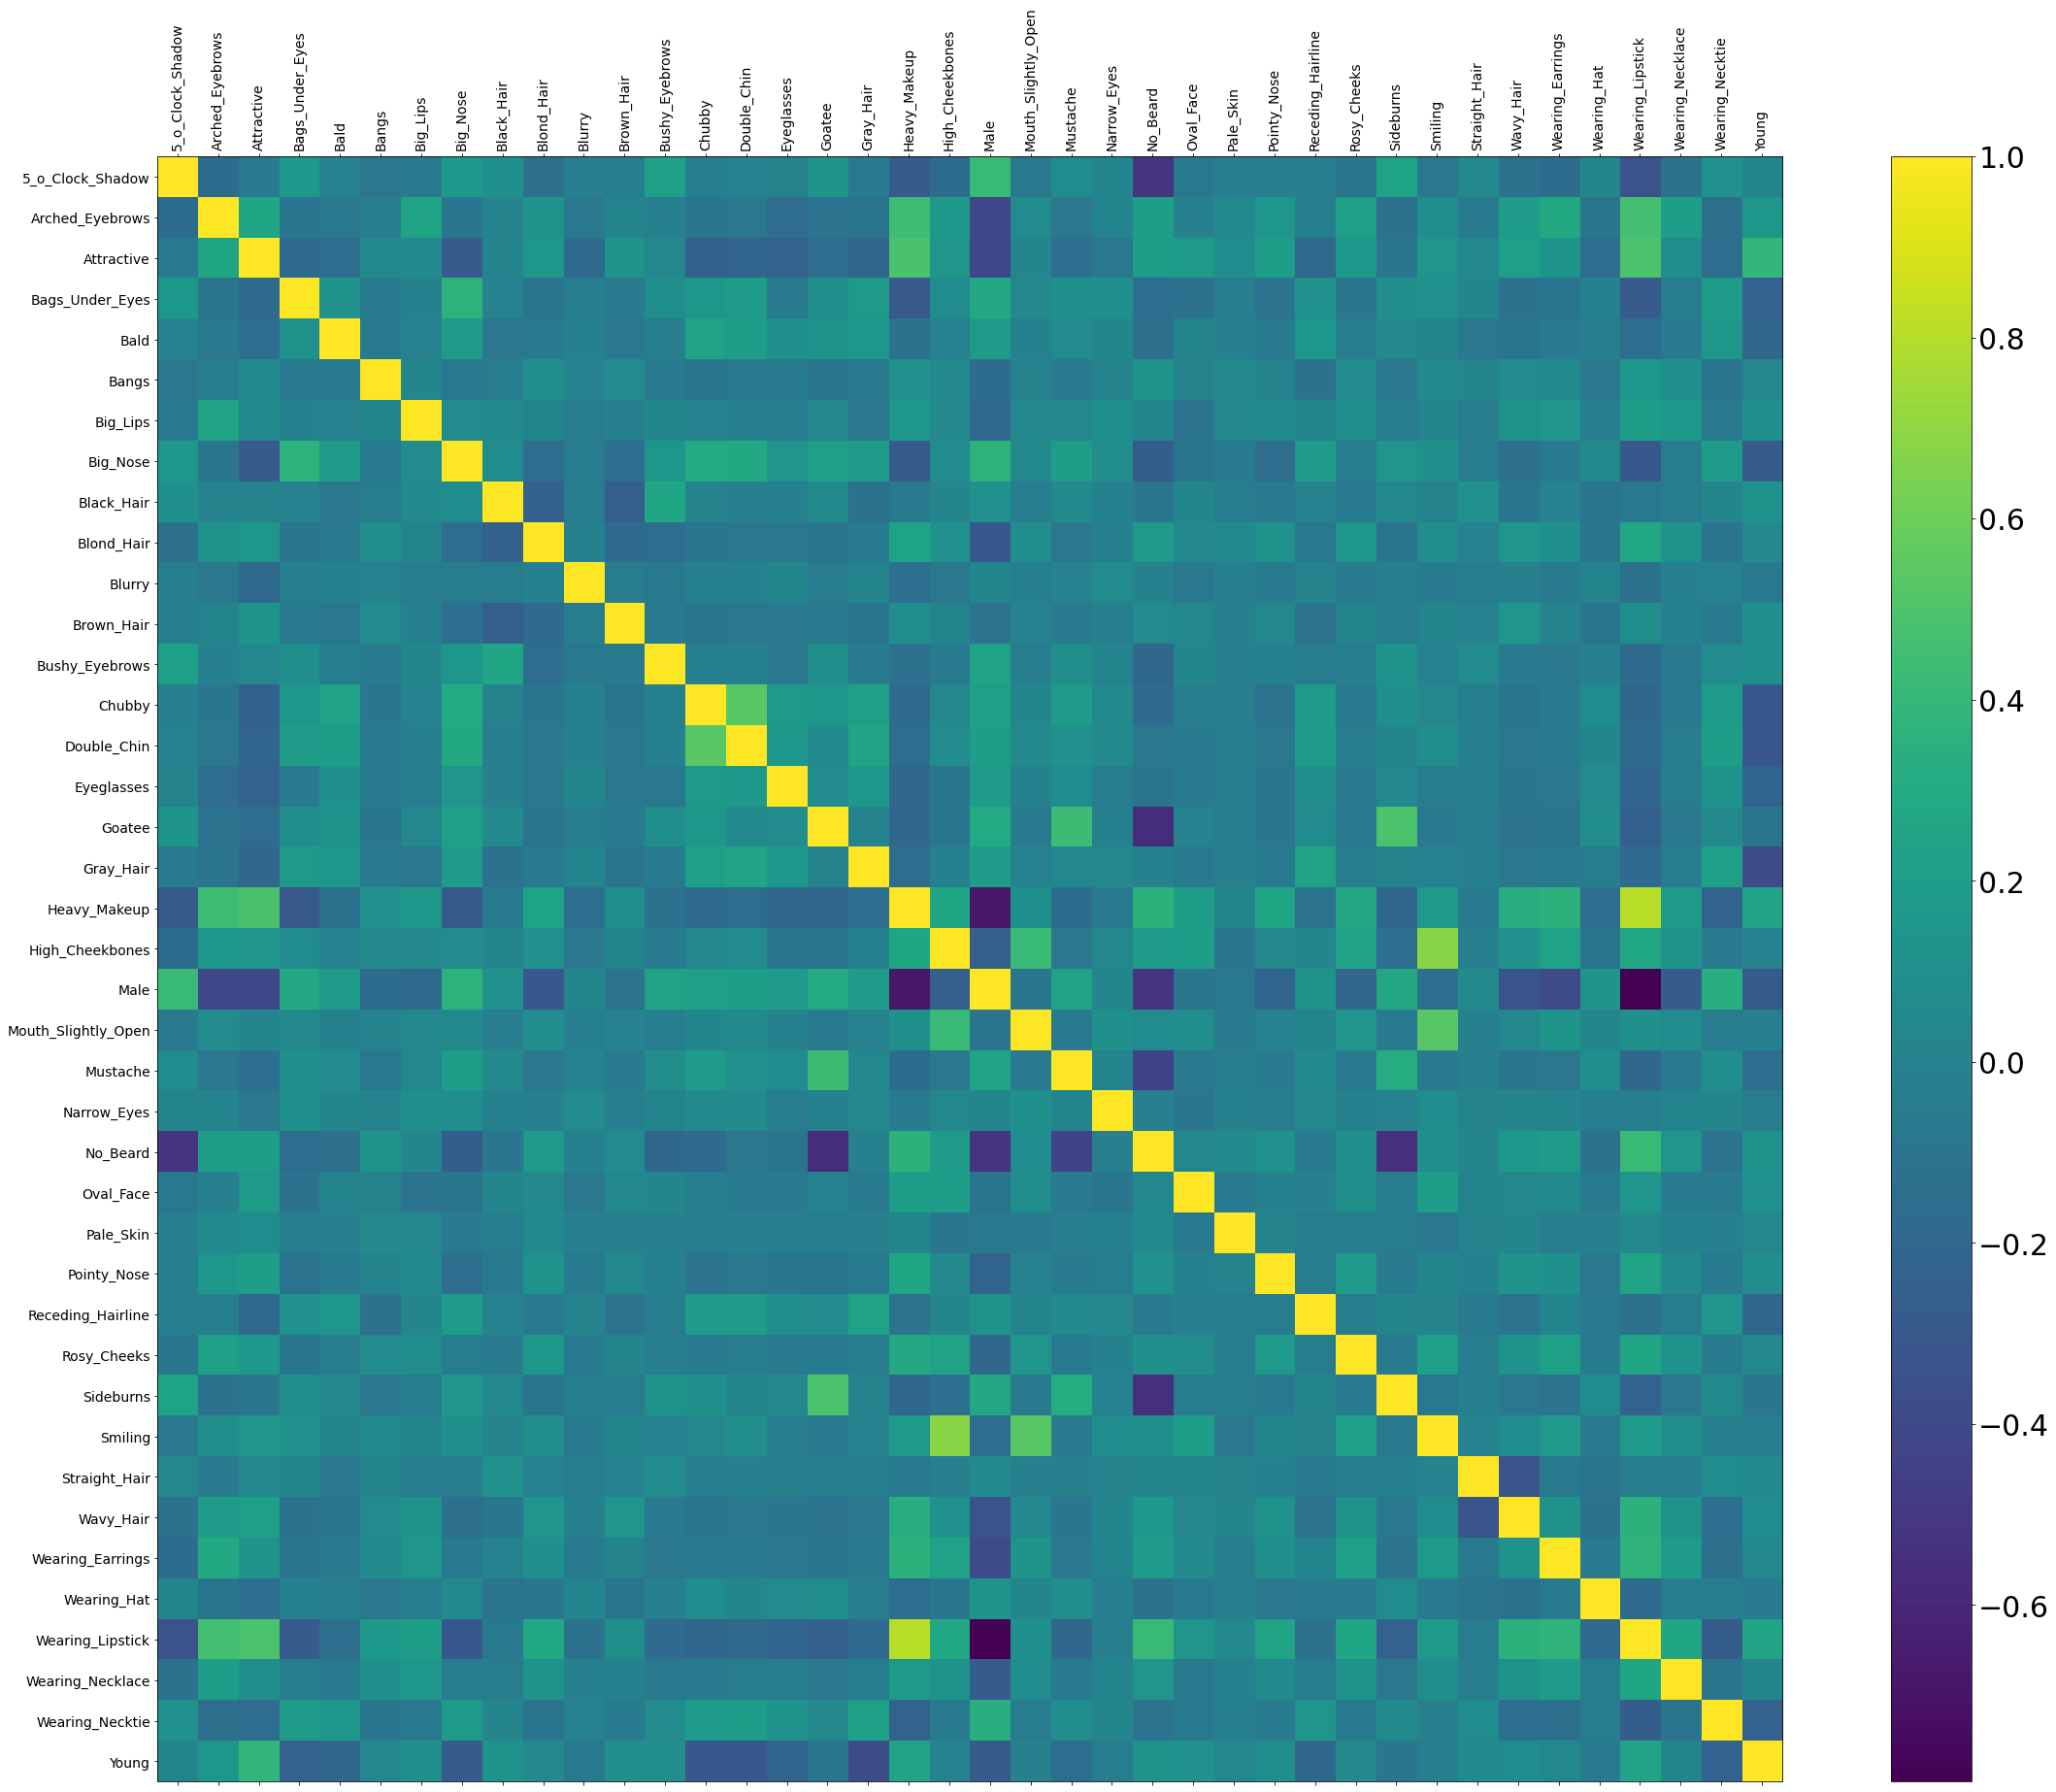

In [157]:
f = plt.figure(figsize=(40, 30))

plt.matshow(df_attr.corr(), fignum=f.number)

plt.xticks(range(df_attr.select_dtypes(['number']).shape[1]), df_attr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_attr.select_dtypes(['number']).shape[1]), df_attr.select_dtypes(['number']).columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

Можно увидеть некоторые очевидные корреляции: к примеру, мужчины никогда не используют помаду, поэтому эти два атрибута очень сильно скоррелированны. С другой стороны, яркая помада имеет сильную корреляцию с ярким макияжем.

Интересно выбрать пару скореллированных меток, и посмотреть, поможет ли это нейросети лучше их распознавать.

Выберем несколько меток с различными корреляциями и распределениями. В качестве хорошо сбалансированных меток возьмем Male, Wearing_Lipstick и Smiling. Первые две метки сильно скореллированы между собой, посмотрим, скажется ли это на том, насколько хорошо нейросети будут их распознавать. Дополнительно возьмем одну среднесбалансированную метку, к примеру, Big_Lips, и одну совсем плохо сбалансированную, например Mustache. На этих пяти метках и будем проводить наше исследование.

In [158]:
attributes = ['Male', 'Wearing_Lipstick', 'Smiling', 'Big_Lips', 'Mustache']

## Предварительная обработка данных

Попробуем преобразовать картинки в более удобный вид, в частности, в обычный вектор чисел. Для наглядности, сначала проведем преобразования только над первой картинкой. Дополнительно уменьшим размер, чтобы уменьшить время обучения.

(89, 109)


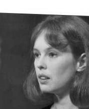

In [159]:
compr_ratio = 2

big_img = Image.open(IMAGE_PATH + example).convert('L')
small_size = (big_img.size[0] // compr_ratio, big_img.size[1] // compr_ratio)
img = big_img.resize(small_size)
print(small_size)
img

In [160]:
from sklearn import preprocessing

img_array = np.array(img)
final_array = (np.concatenate(img_array).reshape(1, -1)).astype('float32') / 255
print(final_array)
image_size = final_array.size
print(final_array.shape)

[[1.         1.         1.         ... 0.2        0.19607843 0.20392157]]
(1, 9701)


Теперь применим это ко всем картинкам, чтобы сформировать соответствующий DataFrame.

In [161]:
def create_features_from_indexes(indexes, columns, verboze=1):
    x = pd.DataFrame(index=indexes, columns=columns)
    counter = 0
    for img_index in indexes:
        img = Image.open(IMAGE_PATH + img_index).convert('L').resize(small_size)
        img_array = (np.concatenate(np.array(img)).reshape(1, -1)).astype('float32') / 255
        x.loc[img_index] = img_array
        counter += 1
        if (verboze == 1 and counter % 1000 == 0):
            print(counter)
    return x

Авторы рекомендуют разбивать данные на train и test следующим образом:
> Recommended: \
1-162770 are training\
162771-182637 are validation\
182638-202599 are testing

В рамках данной работы я не обладаю достаточными мощностями, для того чтобы рассматривать такое количество данных, поэтому выберем 4000 картинок для обучения, 1000 для валидации и 1000 для тестирования. Выбирать будем случайным образом из первых 17000 картинок.

In [162]:
y_train = df_attr.iloc[:df_size].sample(n=4000, random_state=42)
y_val = df_attr.iloc[:df_size].drop(y_train.index.tolist()).sample(n=1000, random_state=42)
y_test = df_attr.iloc[:df_size].drop(y_train.index.tolist())\
        .drop(y_val.index.tolist()).sample(n=1000, random_state=42)

print(y_train.shape, y_val.shape, y_test.shape)
y_test

(4000, 40) (1000, 40) (1000, 40)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
002741.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
009217.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
002427.jpg,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
012985.jpg,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
000538.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
008222.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1
014057.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
005634.jpg,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
003897.jpg,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


Применим к каждой выборке преобразование картинок, создав соответственно тренировочный, валидационный и тестовый набор фичей.

In [232]:
start_time = time.time()

x_train = create_features_from_indexes(y_train.index, range(image_size))
x_val = create_features_from_indexes(y_val.index, range(image_size))
x_test = create_features_from_indexes(y_test.index, range(image_size))

print("--- %s seconds ---" % (time.time() - start_time))

1000
2000
3000
4000
1000
1000
--- 25.405062675476074 seconds ---


In [164]:
# start_time = time.time()

# x_train.to_csv(PATH + 'faces_train_dataset.csv')
# x_val.to_csv(PATH + 'faces_val_dataset.csv')
# x_test.to_csv(PATH + 'faces_test_dataset.csv')

# print("--- %s seconds ---" % (time.time() - start_time))

In [165]:
# start_time = time.time()

# x_train.to_csv('faces_train_dataset.csv')
# x_val.to_csv('faces_val_dataset.csv')
# x_test.to_csv('faces_test_dataset.csv')

# print("--- %s seconds ---" % (time.time() - start_time))

In [166]:
# start_time = time.time()

# x_train = pd.read_csv('/content/drive/MyDrive/content/faces_train_dataset.csv', index_col='Unnamed: 0')
# x_test = pd.read_csv('/content/drive/MyDrive/content/faces_test_dataset.csv', index_col='Unnamed: 0')
# x_val = pd.read_csv('/content/drive/MyDrive/content/faces_val_dataset.csv', index_col='Unnamed: 0')

# print("--- %s seconds ---" % (time.time() - start_time))

In [167]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9661,9662,9663,9664,9665,9666,9667,9668,9669,9670,9671,9672,9673,9674,9675,9676,9677,9678,9679,9680,9681,9682,9683,9684,9685,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696,9697,9698,9699,9700
010942.jpg,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0.0392157,0.266667,0.521569,0.603922,0.623529,0.603922,0.564706,0.572549,0.670588,0.701961,0.694118,0.705882,0.705882,0.705882,0.678431,0.690196,0.701961,0.698039,0.694118,0.670588,0.631373,0.619608,0.619608,0.635294,0.654902,0.662745,0.666667,0.623529,0.584314,0.411765,0.266667,0.223529,0.2,0.211765,0.207843,0.215686,0.219608,0.2,0.196078,0.203922
005251.jpg,0.866667,0.866667,0.823529,0.741176,0.690196,0.545098,0.294118,0.176471,0.105882,0.054902,0.0431373,0.0431373,0.0470588,0.0470588,0.0588235,0.0509804,0.0470588,0.0705882,0.0745098,0.0470588,0.0588235,0.0470588,0.0313726,0.0470588,0.0627451,0.0509804,0.0627451,0.0705882,0.0470588,0.0666667,0.0901961,0.0980392,0.109804,0.109804,0.133333,0.145098,0.129412,0.109804,0.109804,0.0862745,...,0.172549,0.168627,0.160784,0.164706,0.172549,0.168627,0.160784,0.168627,0.145098,0.133333,0.137255,0.133333,0.129412,0.137255,0.133333,0.133333,0.137255,0.145098,0.14902,0.145098,0.141176,0.152941,0.137255,0.145098,0.168627,0.133333,0.164706,0.294118,0.384314,0.537255,0.690196,0.776471,0.870588,0.87451,0.929412,0.905882,0.698039,0.796078,0.709804,0.462745
010293.jpg,0.784314,0.807843,0.839216,0.847059,0.835294,0.835294,0.854902,0.886275,0.937255,0.964706,0.964706,0.960784,0.952941,0.729412,0.32549,0.227451,0.207843,0.196078,0.2,0.207843,0.203922,0.188235,0.164706,0.14902,0.188235,0.34902,0.462745,0.431373,0.392157,0.364706,0.356863,0.376471,0.4,0.415686,0.392157,0.356863,0.352941,0.360784,0.34902,0.333333,...,0.811765,0.807843,0.796078,0.792157,0.788235,0.776471,0.760784,0.729412,0.72549,0.745098,0.733333,0.741176,0.745098,0.670588,0.533333,0.509804,0.509804,0.513726,0.580392,0.635294,0.670588,0.698039,0.666667,0.603922,0.556863,0.568627,0.592157,0.576471,0.556863,0.576471,0.54902,0.501961,0.529412,0.603922,0.615686,0.631373,0.686275,0.670588,0.627451,0.615686
002267.jpg,0.705882,0.709804,0.713726,0.713726,0.713726,0.713726,0.713726,0.713726,0.717647,0.717647,0.72549,0.72549,0.72549,0.721569,0.721569,0.72549,0.72549,0.72549,0.733333,0.733333,0.72549,0.729412,0.737255,0.741176,0.737255,0.737255,0.737255,0.737255,0.741176,0.745098,0.741176,0.737255,0.737255,0.729412,0.729412,0.737255,0.741176,0.741176,0.74902,0.74902,...,0.219608,0.176471,0.196078,0.247059,0.219608,0.196078,0.2,0.254902,0.290196,0.254902,0.411765,0.439216,0.478431,0.541176,0.537255,0.701961,0.858824,0.886275,0.913725,0.980392,0.992157,0.988235,0.992157,0.996078,0.972549,0.882353,0.701961,0.619608,0.552941,0.462745,0.462745,0.482353,0.478431,0.482353,0.462745,0.52549,0.596078,0.588235,0.564706,0.545098
006399.jpg,0.870588,0.819608,0.819608,0.882353,0.933333,0.933333,0.933333,0.933333,0.941176,0.941176,0.941176,0.941176,0.945098,0.941176,0.941176,0.945098,0.941176,0.945098,0.94902,0.94902,0.952941,0.952941,0.952941,0.952941,0.945098,0.945098,0.945098,0.945098,0.945098,0.941176,0.933333,0.929412,0.933333,0.929412,0.921569,0.917647,0.905882,0.898039,0.894118,0.898039,...,0.745098,0.752941,0.745098,0.741176,0.729412,0.72549,0.745098,0.729412,0.694118,0.67451,0.670588,0.568627,0.364706,0.333333,0.352941,0.329412,0.407843,0.431373,0.439216,0.501961,0.521569,0.482353,0.505882,0.454902,0.419608,0.403922,0.333333,0.223529,0.2,0.168627,0.239216,0.239216,0.235294,0.192157,0.278431,0.176471,0.0823529,0.101961,0.117647,0.109804


In [168]:
for attribute in attributes:
    print(attribute)
    print(round(y_train[y_train[attribute] == 1].size / y_train.size, 3), '\t',
          round(y_val[y_val[attribute] == 1].size / y_val.size, 3), '\t',
          round(y_test[y_test[attribute] == 1].size / y_test.size, 3), '\t',)

Male
0.419 	 0.413 	 0.414 	
Wearing_Lipstick
0.475 	 0.482 	 0.486 	
Smiling
0.481 	 0.491 	 0.443 	
Big_Lips
0.241 	 0.24 	 0.262 	
Mustache
0.036 	 0.041 	 0.036 	


Как мы уже выяснили ранее, данные не сбалансированы. Это видно и после разбиения на тренировочную, валидационную и тестовую выборки. Данный факт будет необходимо учесть в будущем. В частности, метрика accuracy в такой ситуации будет практически бесполезна, так что в качестве основной метрики будем использовать F-меру.

## Обучение логистической регрессии

Для начала, обучим простую логистическую регрессию на выбранных атрибутах.

In [169]:
sgd_scores = {'train' : [], 'test' : []}

In [170]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

def SGDClassifierForArrtibute(attribute):  
    start = time.time()
    sgd_clf = SGDClassifier(loss='log', tol=1e-1, verbose=0, random_state=42)
    y_train_attribute = y_train[attribute]
    sgd_clf.fit(x_train, y_train_attribute)
    print('time: ', time.time() - start)
    return sgd_clf

def CheckStats(clf, attribute, scores):
    print('Сlassifier for ', attribute)
    pred_y_train = clf.predict(x_train)
    scores['train'].append(f1_score(pred_y_train, y_train[attribute]))
    print('train f1 score: ', f1_score(pred_y_train, y_train[attribute]))
    pred_y_test = clf.predict(x_test)
    scores['test'].append(f1_score(pred_y_test, y_test[attribute]))
    print('test f1 score: ', f1_score(pred_y_test, y_test[attribute]))

def ClassifierAndStats(attribute):
    sgd_male = SGDClassifierForArrtibute(attribute)
    CheckStats(sgd_male, attribute, sgd_scores)
    print()

In [171]:
for attribute in attributes:
    ClassifierAndStats(attribute)

time:  9.432366609573364
Сlassifier for  Male
train f1 score:  0.8840952994204766
test f1 score:  0.822477650063857

time:  9.904783487319946
Сlassifier for  Wearing_Lipstick
train f1 score:  0.8918128654970761
test f1 score:  0.8604427333974976

time:  10.116036176681519
Сlassifier for  Smiling
train f1 score:  0.9543415149115863
test f1 score:  0.8492520138089757

time:  14.789923191070557
Сlassifier for  Big_Lips
train f1 score:  0.7282793867120954
test f1 score:  0.40924092409240925

time:  7.0797810554504395
Сlassifier for  Mustache
train f1 score:  0.4212076583210604
test f1 score:  0.23204419889502767



## Обучение случайного леса

Случайный лес - структура, на основе решающих деревьев. Это не очень сложная структура, однако часто выдает очень хорошие результаты. Посмотрим, сможет ли случайный лес дать нам результат лучше, чем нейронные сети.

Для каждой метки будем подбирать наилучшие параметры дерева. Чтобы сократить время обучения, будем использовать RandomizedSearchCV. Вместо разбиения множества на 5 подмножеств на кросс-валидации, будем разделять множество только на два, как если бы мы тренировали дерево и потом валидировали.

In [172]:
tree_scores = {'train' : [], 'test' : []}

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def FindBestParams(attribute, verbose=1):
    start = time.time()
    params = {'max_depth' : [1, 4, 7, 10, 12, 15], 
          'min_samples_split' : [2, 6, 10], 
          'min_samples_leaf' : [1, 4, 7, 10]}
    search = RandomizedSearchCV(RandomForestClassifier(), params, scoring='f1', 
                                cv=2, random_state=42, verbose=verbose, n_iter=16)
    search.fit(x_train, y_train[attribute])
    print('---Best params:', search.best_params_, '\t time:', time.time() - start)
    return search.best_estimator_

In [174]:
def ForestAndStatsForAttribute(attribute):
    print(attribute)
    clf = FindBestParams(attribute, verbose=2)
    clf.fit(x_train, y_train[attribute])
    CheckStats(clf, attribute, tree_scores)

In [175]:
ForestAndStatsForAttribute(attributes[0])

Male
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.8s
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  12.8s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  13.3s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.3s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.3s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.8s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=  10.0s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.9s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=10; total time=  12.7s
[CV] END max_depth=12, min

In [176]:
ForestAndStatsForAttribute(attributes[1])

Wearing_Lipstick
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.8s
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  13.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  12.9s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.3s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.3s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.9s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=  10.0s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=10; total time=  12.4s
[CV] END max_d

In [177]:
ForestAndStatsForAttribute(attributes[2])

Smiling
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.8s
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  12.5s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  12.7s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.3s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.6s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.9s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.8s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=10; total time=  12.4s
[CV] END max_depth=12, 

In [178]:
ForestAndStatsForAttribute(attributes[3])

Big_Lips
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.8s
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  14.2s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  14.4s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.1s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.6s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.7s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=10; total time=  13.1s
[CV] END max_depth=12,

In [179]:
ForestAndStatsForAttribute(attributes[4])

Mustache
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.8s
[CV] END max_depth=1, min_samples_leaf=4, min_samples_split=6; total time=   4.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  13.2s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10; total time=  13.1s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   7.0s
[CV] END max_depth=4, min_samples_leaf=7, min_samples_split=2; total time=   6.9s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.1s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6; total time=   9.2s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=10; total time=  12.2s
[CV] END max_depth=12,

## Обучение полносвязной нейронной сети

In [180]:
import torch
from torch import nn
from torch.nn.functional import one_hot
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [233]:
model_adam_scores = {'train' : [], 'test' : []}
model_sgd_scores = {'train' : [], 'test' : []}
image_size = 9701

In [234]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

input_size = image_size
hidden_sizes = [512, 256, 128]
output_size = 2

x_train_tensor = torch.from_numpy(x_train.to_numpy().astype('float32')).to(device)
x_val_tensor = torch.from_numpy(x_val.to_numpy().astype('float32')).to(device)
x_test_tensor = torch.from_numpy(x_test.to_numpy().astype('float32')).to(device)

In [235]:
def CreateModel():
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[2], output_size),
                          nn.LogSoftmax(dim=1))
    return model

In [236]:
def CreateParametres(attribute, model):
    y_train_tensor = torch.from_numpy(y_train[attribute].to_numpy()).to(torch.int64)                               

    y_val_tensor = torch.from_numpy(y_val[attribute].to_numpy()).to(torch.int64)  

    y_test_tensor = torch.from_numpy(y_test[attribute].to_numpy()).to(torch.int64)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=100)

    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_dataset, batch_size=100)

    if torch.cuda.is_available():
        model = model.to(device)
        
    dataloaders  = {'train':train_loader, 'val':val_loader}
    return dataloaders

In [237]:
def TrainModel(model, dataloaders, n_epochs, optimizer, verbose=0):
    criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    if torch.cuda.is_available():
        model = model.to(device)
        criterion = criterion.to(device)

    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        batch_losses = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            model.train()
            yhat = model(x_batch)

            loss = criterion(yhat, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_losses.append(loss.item())
        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val_batch, y_val_batch in val_loader:
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)
                model.eval()
                yhat = model(x_val_batch)
                val_loss = criterion(yhat, y_val_batch).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)
        if (verbose == 1):
          print(f"[{epoch}] Training loss: {training_loss}\t Validation loss: {validation_loss}")
    return training_losses, validation_losses

In [238]:
def CheckModelStats(model, attribute, scores, optimizer_name):
    print('Сlassifier for ', attribute)
    pred_y_train = model(x_train_tensor).argmax(axis=1)
    print('train f1 score: ', f1_score(pred_y_train.cpu().numpy(), y_train[attribute]))
    pred_y_test = model(x_test_tensor).argmax(axis=1)
    print('test f1 score: ', f1_score(pred_y_test.cpu().numpy(), y_test[attribute]))
    
    scores['train'].append(f1_score(pred_y_train.cpu().numpy(), y_train[attribute]))
    scores['test'].append(f1_score(pred_y_test.cpu().numpy(), y_test[attribute]))

In [239]:
def CreateOptimizer(optimizer_name, model, momentum):
    optimizer = None
    if (optimizer_name == 'Adam'):
      optimizer = optim.Adam(params=model.parameters(), lr=3e-4)
    if (optimizer_name == 'SGD'):
      optimizer = optim.SGD(params=model.parameters(), lr=1e-3, momentum=momentum)
    return optimizer

In [240]:
def ModelForAttribute(attribute, optimizer_name, n_epochs=10, verbose=0, momentum=0):
    model = CreateModel()
    dataloaders = CreateParametres(attribute, model)
    optimizer = CreateOptimizer(optimizer_name, model, momentum)
    training_losses, validation_losses = TrainModel(model, dataloaders, n_epochs, optimizer, verbose)
    if (optimizer_name == 'Adam'):
        CheckModelStats(model, attribute, model_adam_scores, optimizer_name)
    if (optimizer_name == 'SGD'):
        CheckModelStats(model, attribute, model_sgd_scores, optimizer_name)
    return training_losses, validation_losses

In [241]:
def PrintGraphics(training_losses, validation_losses):
    f, ax1 = plt.subplots()   
    ax1.plot(training_losses, 'b')
    ax1.plot(validation_losses, 'r')

Рассмотрим различные оптимайзеры, и выберем для каждого оптимальное количество эпох. Подробно разберем на одной метке, к примеру, пол.

Начнем с оптимайзера Adam. Как несложно видеть по графику лосса на тренировочном и валидационном датасете, сеть начинает переобучаться уже примерно на 10-12 эпохе.

Сlassifier for  Male
train f1 score:  0.9512120282295183
test f1 score:  0.8690176322418136


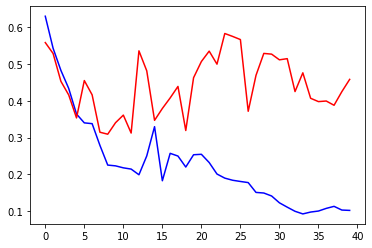

In [242]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=40)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Male
train f1 score:  0.8818132757690231
test f1 score:  0.8478964401294499


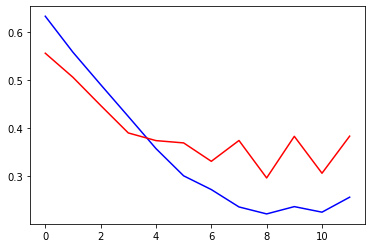

In [243]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)

Теперь рассмотрим оптимайзер SGD. Сначала оставим его параметры по умолчанию.

Сlassifier for  Male
train f1 score:  0.9347355397463656
test f1 score:  0.876117496807152


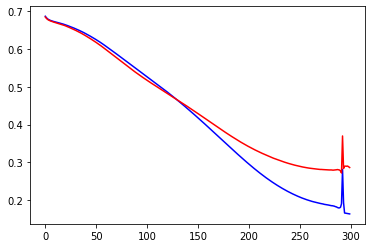

In [244]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'SGD', n_epochs=300)
PrintGraphics(train_losses, val_losses)

Чтобы нейросеть достигла неплохих результатов, нужно провести около трехста эпох, дальше, как видно, она начинает переобучатся. Попробуем изменить моментум.

Сlassifier for  Male
train f1 score:  1.0
test f1 score:  0.905982905982906


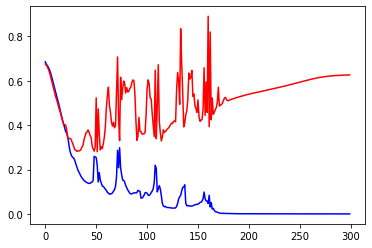

In [245]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'SGD', n_epochs=300, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Здесь сеть начинает очень сильно переобучатся еще не пройдя 50 эпох. Поправим этот параметр.

Сlassifier for  Male
train f1 score:  0.931024531024531
test f1 score:  0.8870967741935485


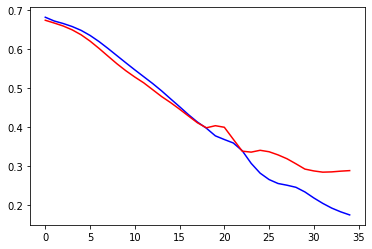

In [246]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'SGD', n_epochs=35, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Male
train f1 score:  0.9263464337700146
test f1 score:  0.8767441860465116
Сlassifier for  Male
train f1 score:  0.886240520043337
test f1 score:  0.8416485900216919
Сlassifier for  Male
train f1 score:  0.8947368421052632
test f1 score:  0.8603104212860311


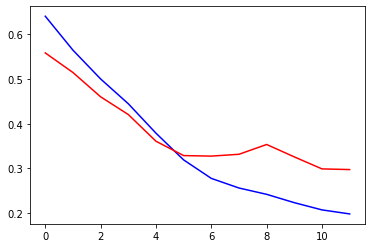

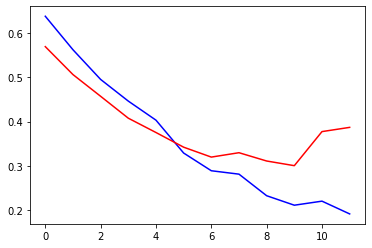

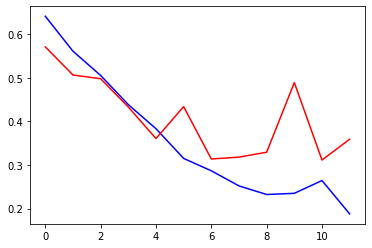

In [247]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)

Можно сделать вывод, что оптимизатор Adam в данном случае показывает себя гораздо лучше и сходится гораздо быстрее, однако является менее предсказуемым, чем SGD. С Adam результаты обучения сильно изменяются от запуска к запуску, и очень сильно зависят от случайных начальных весов. С SGD мы получаем более долгое, однако более стабильное обучение. 

Проведем обучение на остальных параметрах. На данном этапе мы создаем отдельную сеть для каждого параметра.

In [248]:
model_adam_scores = {'train' : [], 'test' : []}
model_sgd_scores = {'train' : [], 'test' : []}

Сlassifier for  Male
train f1 score:  0.8780487804878049
test f1 score:  0.8367567567567569
Сlassifier for  Male
train f1 score:  0.9320105048147067
test f1 score:  0.8852459016393444


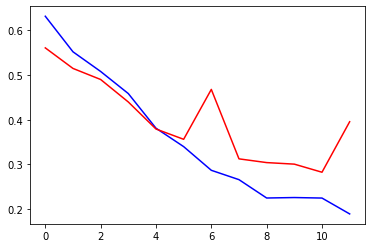

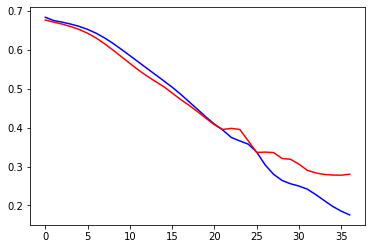

In [249]:
train_losses, val_losses = ModelForAttribute(attributes[0], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[0], 'SGD', n_epochs=37, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Wearing_Lipstick
train f1 score:  0.8813467282106978
test f1 score:  0.8423280423280424
Сlassifier for  Wearing_Lipstick
train f1 score:  0.9130547625227097
test f1 score:  0.8732394366197184


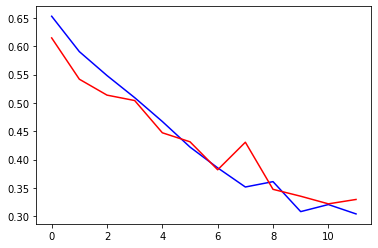

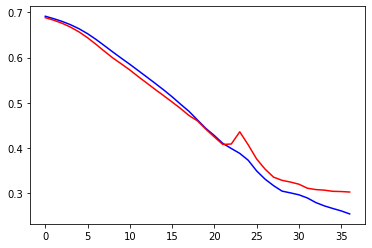

In [250]:
train_losses, val_losses = ModelForAttribute(attributes[1], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[1], 'SGD', n_epochs=37, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Smiling
train f1 score:  0.8853037559868918
test f1 score:  0.8630434782608696
Сlassifier for  Smiling
train f1 score:  0.9184890656063619
test f1 score:  0.8629550321199144


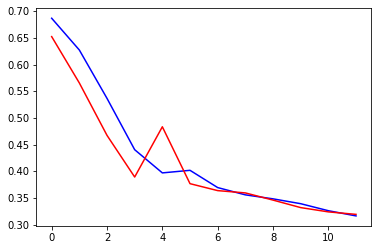

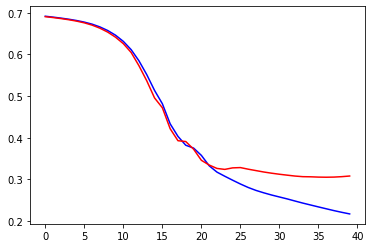

In [251]:
train_losses, val_losses = ModelForAttribute(attributes[2], 'Adam', n_epochs=12)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[2], 'SGD', n_epochs=40, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Big_Lips
train f1 score:  0.17295308187672492
test f1 score:  0.10452961672473866
Сlassifier for  Big_Lips
train f1 score:  0.34636015325670494
test f1 score:  0.15337423312883436


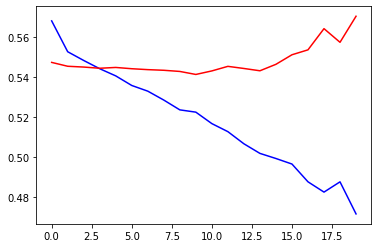

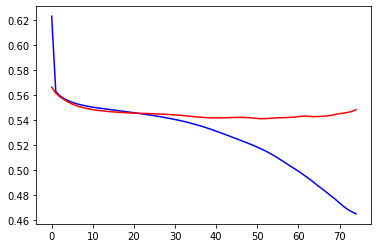

In [252]:
train_losses, val_losses = ModelForAttribute(attributes[3], 'Adam', n_epochs=20)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[3], 'SGD', n_epochs=75, momentum=0.9)
PrintGraphics(train_losses, val_losses)

Сlassifier for  Mustache
train f1 score:  0.6579804560260586
test f1 score:  0.3055555555555556
Сlassifier for  Mustache
train f1 score:  0.14102564102564102
test f1 score:  0.049999999999999996


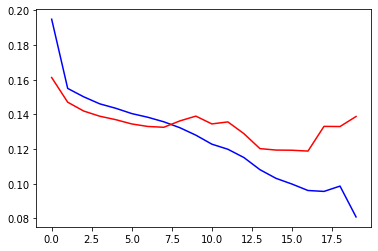

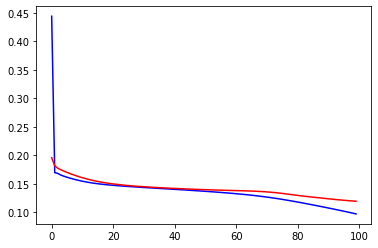

In [253]:
train_losses, val_losses = ModelForAttribute(attributes[4], 'Adam', n_epochs=20)
PrintGraphics(train_losses, val_losses)
train_losses, val_losses = ModelForAttribute(attributes[4], 'SGD', n_epochs=100, momentum=0.9)
PrintGraphics(train_losses, val_losses)

С последними двумя сильно несбалансированными метками наша полносвязная сеть справляется очень плохо, вне зависимости от количества эпох.


## Обучение сверточной сети

### Предварительная обработка данных

В качестве архитектуры сверточной нейронной сети я выбрала LeNet. Для применения этой архитектуры изображение должно быть чернобелое, и сжатое до размера 32 на 32 пикселя.

In [202]:
from torchvision import transforms

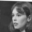

In [203]:
preprocess = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32)
])
new_img = preprocess(big_img).convert('L')
new_img

In [204]:
x = np.empty((0, 1, 32, 32))
img = preprocess(Image.open(IMAGE_PATH + example)).convert('L')
img_array = (np.array(img)).reshape(1, 1, 32, 32).astype('float32') / 255
print(img_array.shape)
print(x.shape)
x = np.concatenate((x, img_array), axis=0)
print(x.shape)

(1, 1, 32, 32)
(0, 1, 32, 32)
(1, 1, 32, 32)


In [205]:
def ImageToNumpy(indexes, columns, verboze=1):
    x = np.empty((0, 1, 32, 32))
    counter = 0
    for img_index in indexes:
        img = preprocess(Image.open(IMAGE_PATH + img_index)).convert('L')
        img_array = (np.array(img)).reshape(1, 1, 32, 32).astype('float32') / 255

        x = x = np.concatenate((x, img_array), axis=0)

        counter += 1
        if (verboze == 1 and counter % 1000 == 0):
            print(x.shape)
            print(counter)
    return x

In [206]:
start_time = time.time()

x_train = ImageToNumpy(y_train.index, range(image_size))
x_val = ImageToNumpy(y_val.index, range(image_size))
x_test = ImageToNumpy(y_test.index, range(image_size))

print("--- %s seconds ---" % (time.time() - start_time))

(1000, 1, 32, 32)
1000
(2000, 1, 32, 32)
2000
(3000, 1, 32, 32)
3000
(4000, 1, 32, 32)
4000
(1000, 1, 32, 32)
1000
(1000, 1, 32, 32)
1000
--- 34.187211990356445 seconds ---


### Обучение модели

Теперь будем обучать нашу модель.

In [207]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [208]:
cnn_model_scores = {'train' : [], 'test' : []}

In [209]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.from_numpy(x_train.astype('float32')).to(device)
x_val_tensor = torch.from_numpy(x_val.astype('float32')).to(device)
x_test_tensor = torch.from_numpy(x_test.astype('float32')).to(device)
x_train.shape

(4000, 1, 32, 32)

In [210]:
def CreateLeNetModel():
    model = LeNet5(2)
    return model

In [211]:
def CreateCNNParametres(attribute, model):
    y_train_tensor = torch.from_numpy(y_train[attribute].to_numpy()).to(torch.int64)                               

    y_val_tensor = torch.from_numpy(y_val[attribute].to_numpy()).to(torch.int64)  

    y_test_tensor = torch.from_numpy(y_test[attribute].to_numpy()).to(torch.int64)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=100)

    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_dataset, batch_size=100)

    if torch.cuda.is_available():
        model = model.to(device)
        
    dataloaders  = {'train':train_loader, 'val':val_loader}
    return dataloaders

In [212]:
def TrainCNNModel(model, dataloaders, n_epochs, optimizer, verbose=0):
    criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    if torch.cuda.is_available():
        model = model.to(device)
        criterion = criterion.to(device)

    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            model.train()
            yhat = model(x_batch)[0]

            loss = criterion(yhat, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_losses.append(loss.item())
        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val_batch, y_val_batch in val_loader:
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)
                model.eval()
                yhat = model(x_val_batch)[0]
                val_loss = criterion(yhat, y_val_batch).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)
        if (verbose == 1):
          print(f"[{epoch}] Training loss: {training_loss}\t Validation loss: {validation_loss}")
    return training_losses, validation_losses

In [213]:
def CheckModelStats(model, attribute, scores):
    print('LeNet Сlassifier for ', attribute)
    pred_y_train = model(x_train_tensor)[0].argmax(axis=1)
    print('train f1 score: ', f1_score(pred_y_train.cpu().numpy(), y_train[attribute]))
    pred_y_test = model(x_test_tensor)[0].argmax(axis=1)
    print('test f1 score: ', f1_score(pred_y_test.cpu().numpy(), y_test[attribute]))
    
    scores['train'].append(f1_score(pred_y_train.cpu().numpy(), y_train[attribute]))
    scores['test'].append(f1_score(pred_y_test.cpu().numpy(), y_test[attribute]))

In [214]:
def CNNModelForAttribute(attribute, optimizer_name, n_epochs=10, verbose=0, momentum=0):
    model = CreateLeNetModel()
    dataloaders = CreateCNNParametres(attribute, model)
    optimizer = CreateOptimizer(optimizer_name, model, momentum)
    training_losses, validation_losses = TrainCNNModel(model, dataloaders, n_epochs, optimizer, verbose)
    CheckModelStats(model, attribute, cnn_model_scores)
    return training_losses, validation_losses

LeNet Сlassifier for  Male
train f1 score:  0.8959952181709504
test f1 score:  0.8846153846153846


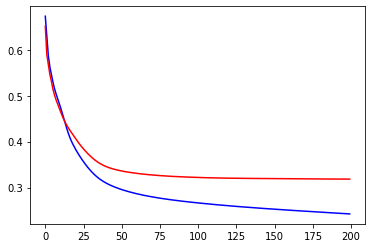

In [215]:
train_losses, val_losses = CNNModelForAttribute(attributes[0], 'Adam', n_epochs=200)
PrintGraphics(train_losses, val_losses)

LeNet Сlassifier for  Wearing_Lipstick
train f1 score:  0.8818897637795275
test f1 score:  0.8700102354145343


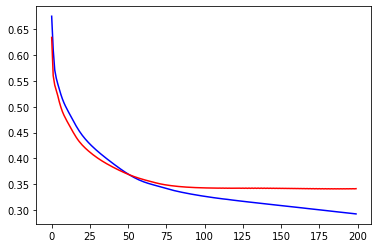

In [216]:
train_losses, val_losses = CNNModelForAttribute(attributes[1], 'Adam', n_epochs=200)
PrintGraphics(train_losses, val_losses)

LeNet Сlassifier for  Smiling
train f1 score:  0.8982735723771581
test f1 score:  0.8430913348946136


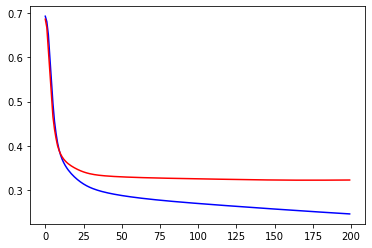

In [217]:
train_losses, val_losses = CNNModelForAttribute(attributes[2], 'Adam', n_epochs=200)
PrintGraphics(train_losses, val_losses)

LeNet Сlassifier for  Big_Lips
train f1 score:  0.062015503875968984
test f1 score:  0.0437956204379562


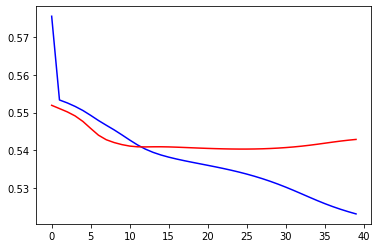

In [218]:
train_losses, val_losses = CNNModelForAttribute(attributes[3], 'Adam', n_epochs=40)
PrintGraphics(train_losses, val_losses)

LeNet Сlassifier for  Mustache
train f1 score:  0.23529411764705882
test f1 score:  0.16666666666666666


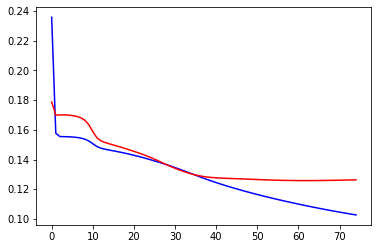

In [219]:
train_losses, val_losses = CNNModelForAttribute(attributes[4], 'Adam', n_epochs=75)
PrintGraphics(train_losses, val_losses)

На плохо сбалансированных признаках сверточная нейросеть тоже показывает себя плохо.

## Статистика

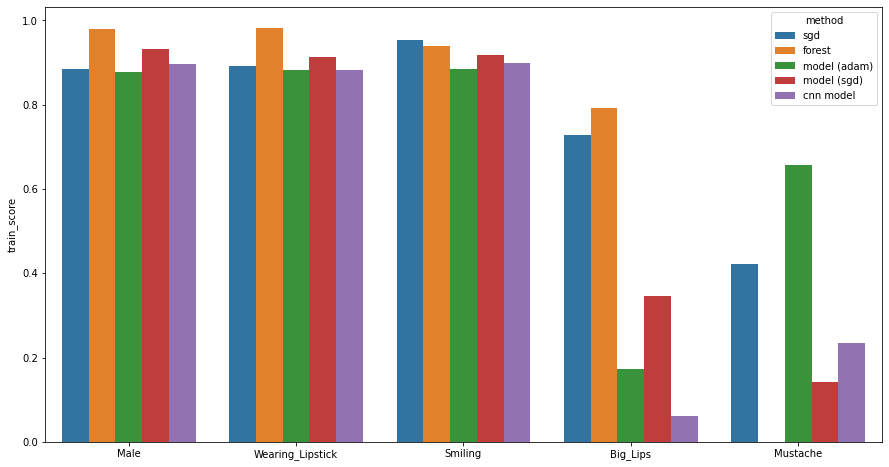

In [254]:
stats_attributes = attributes * 5
# print(model_adam_scores)
stats = pd.DataFrame({'train_score': sgd_scores['train'] + tree_scores['train'] \
                      + model_adam_scores['train'] + model_sgd_scores['train'] \
                      + cnn_model_scores['train'], 
                      'test_score': sgd_scores['test'] + tree_scores['test'] \
                      + model_adam_scores['test'] + model_sgd_scores['test'] \
                      + cnn_model_scores['test'], 
                      'method' : ['sgd'] * 5 + ['forest'] * 5 + ['model (adam)'] * 5 + ['model (sgd)'] * 5 + ['cnn model'] * 5}, 
                     index=stats_attributes)

plt.figure(figsize=(15,8))
sns.barplot(data=stats, x=stats.index, y='train_score', hue='method')

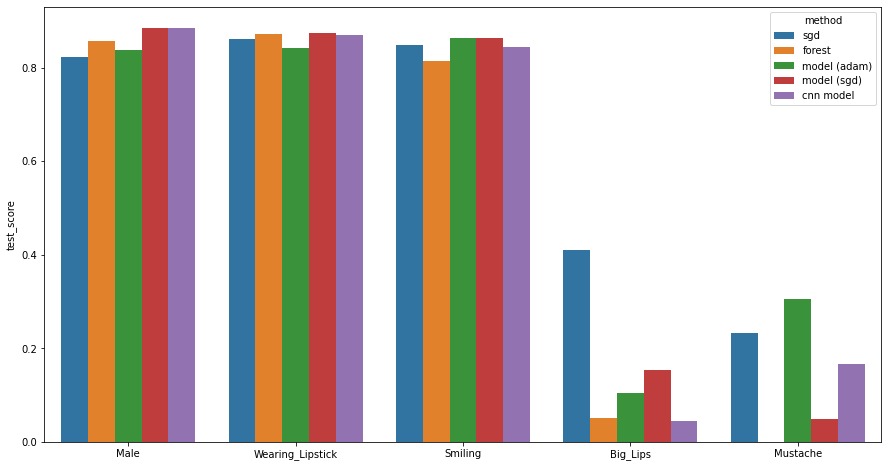

In [255]:
plt.figure(figsize=(15,8))
sns.barplot(data=stats, x=stats.index, y='test_score', hue='method')

На сбалансированных классах все методы справляются довольно хорошо, имеются лишь небольшие отличия. В то время как на плохо сбалансированных неплохой результат показывают только логистическая регрессия и полносвязная нейронная сеть.